# LSTM Neural Network
This script has the objective of converting output of the log filter (positions) into the machine learning model using keras.

In [1]:
# Essential imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# LSTM library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# File Management
import json

# Debug
from datetime import datetime
import time

2022-04-23 12:31:07.620078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 12:31:07.620102: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First let's define the Hyper Parameters and global variables used on the algorithm.

In [58]:
PAST_TIME_STEPS = 2 # Number of past steps that will be stored on the memory

# LABEL_COLUMN = 0 # Column on the object returned by the filtered log
# FEATURE_COLUMNS_RANGE = (0,0)

TRAINING_PATH = "./training_model/csv_with_labels.csv"
TRAINING_START_ROW = 0 # default 0
TRAINING_END_ROW = 50 # default -1

TEST_PATH = "./training_model/csv_with_labels.csv"
TEST_START_ROW = 50 # default 0
TEST_END_ROW = -1 # default -1

# labels definition
LABELS = ["Short Pass", "Long Pass", "Goal Shot"] 
# TODO: Complete with all labels
# OBS.: These labels will be in the matrix as index values (0..N-1),
# where N is the number of labels
N_NEURONS_LSTM = 50

Here are some functions that will be used on the code. These functions don't have initial configuration because it'll depend how the log filter will be made.

In [65]:
def get_filtered_data(path="", starting_row=0, ending_row=-1):
    """Given a path to a csv file, returns the timestamp and the matrix """

    training_csv = pd.read_csv(path, header=None).values
    timestamps = training_csv[starting_row:ending_row,0]
    matrix = training_csv[starting_row:ending_row, 1:]

    return timestamps, matrix


Get the data and plot the graph

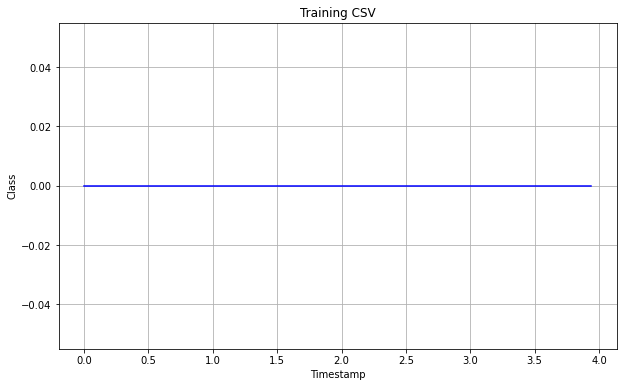

In [79]:
timestamps_training, positions_training = get_filtered_data(path=TRAINING_PATH, starting_row=TRAINING_START_ROW, ending_row=TRAINING_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_training, positions_training[:,-1] ,color='blue')
plt.title('Training CSV')
plt.xlabel('Timestamp')
plt.ylabel('Class')
plt.grid()
plt.show()


Now it's needed to get and proccess data accordingly

In [67]:



n_examples = len(positions_training)

n_features = positions_training.shape[1] - 1


# Applying normalization
scaler = MinMaxScaler(feature_range=(0,1)) # Apply values to [0, 1]
positions_training_scaled = scaler.fit_transform(positions_training)

# print(f"{positions_training = }")
# print(f"{positions_training_scaled = }")

# Convert training array to the right shape
features_set = []
labels = []

for i in range(PAST_TIME_STEPS, n_examples):
    features_set.append(positions_training_scaled[i-PAST_TIME_STEPS:i, 0:n_features]) # previous N records
    labels.append(positions_training_scaled[i, -1])

# Converting to numpy arrays
features_set, labels = np.array(features_set), np.array(labels)
# print(features_set)
print(f"{features_set.shape[0] = }")
print(f"{features_set.shape[1] = }")
print(f"{features_set.shape[2] = }")

# Converting to the LSTM format where the dimensions are:
# - number of records
# - number of time steps (past steps)
# - number of indicators/features.
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], features_set.shape[2]))

features_set.shape[0] = 48
features_set.shape[1] = 2
features_set.shape[2] = 69


With the data loaded and formatted, now it's time to create the model itself.

In [68]:
# Model initialization
model = Sequential()

# Adding LSTM layer
# a funcao "add" literalmente adiciona um novo layer, que no nosso caso, sera um LSTM

# The fist LSTM parameter is the number of neurons on the node
# The second one is basically true, because we'll add more layers to the model
# The last one is a shape indicating the number of time steps and the number of indicators
model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True, input_shape=(features_set.shape[1], features_set.shape[2])))

# Adding Dropout layer (avoids over-fitting)
model.add(Dropout(0.2))

# Adding three more LSTM and Dropout layers
model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=N_NEURONS_LSTM))
model.add(Dropout(0.2))

# Adding Dense Layer (ending layer...?)
# 1 unit beause we want to predict
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


Training the model

In [69]:
# Training the model
# epochs --> number of iteractions probably
model.fit(features_set, labels, epochs = 12, batch_size = 32)

Epoch 1/12
2/2 [==============================] - 14s 22ms/step - loss: 9.1040e-06
Epoch 2/12
2/2 [==============================] - 0s 27ms/step - loss: 5.5505e-06
Epoch 3/12
2/2 [==============================] - 0s 39ms/step - loss: 8.9896e-06
Epoch 4/12
2/2 [==============================] - 0s 36ms/step - loss: 1.7742e-06
Epoch 5/12
2/2 [==============================] - 0s 37ms/step - loss: 6.4648e-06
Epoch 6/12
2/2 [==============================] - 0s 34ms/step - loss: 1.3726e-06
Epoch 7/12
2/2 [==============================] - 0s 33ms/step - loss: 2.7696e-06
Epoch 8/12
2/2 [==============================] - 0s 30ms/step - loss: 2.1508e-06
Epoch 9/12
2/2 [==============================] - 0s 38ms/step - loss: 1.3765e-06
Epoch 10/12
2/2 [==============================] - 0s 16ms/step - loss: 1.8480e-06
Epoch 11/12
2/2 [==============================] - 0s 25ms/step - loss: 8.9941e-07
Epoch 12/12
2/2 [==============================] - 0s 29ms/step - loss: 1.2123e-06


Plotting our test model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


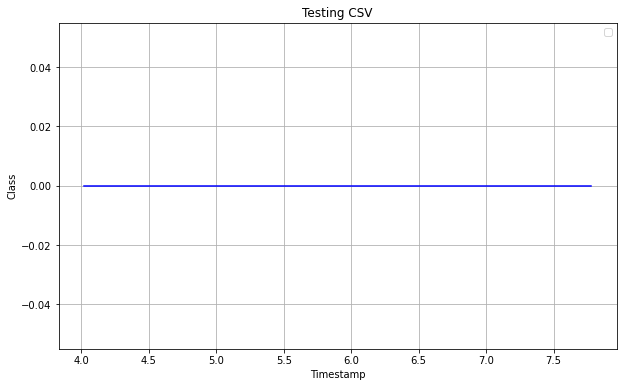

In [78]:
timestamps_testing, positions_testing = get_filtered_data(path=TEST_PATH, starting_row=TEST_START_ROW, ending_row=TEST_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1] ,color='blue')
plt.title('Testing CSV')
plt.xlabel('Timestamp')
plt.ylabel('Class')
plt.grid()
plt.show()